In [1]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit


from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from training import train, create_training_folder, create_callbacks, step_decay_exp
from keras.callbacks import CSVLogger, ModelCheckpoint

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import concatenate, Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, Input, Permute, Concatenate, GlobalMaxPooling1D, MaxPooling1D, Flatten, Activation, Reshape, SpatialDropout1D
from tensorflow.python.keras.regularizers import l2

from training import train, create_training_folder


Using TensorFlow backend.


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [4]:
df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Using sample size: (31373, 12)


In [5]:


# def train_evaluate_model(model, tag, X_train, y_train, X_test, y_test, callbacks = None, epochs = 100):
#     K.clear_session()
        
#     folder = create_training_folder("multemb", tag, add_timestamp=False)
    
#     if callbacks is None:
#         callbacks = []    
# #         callbacks.append(CSVLogger('{}/training_history.csv'.format(folder), append=True, separator=';'))
#         stopper = keras.callbacks.EarlyStopping(monitor="val_f1",
#             # "no longer improving" being defined as "no better than 1e-3 less"
#             min_delta=0.0005,
#             mode="max",
#             # "no longer improving" being further defined as "for at least 8 epochs"
#             patience=20, verbose=1)
#         callbacks.append(stopper)


#     model.fit(X_train, y_train, epochs=epochs, verbose=2, validation_data=(X_test, y_test), callbacks = callbacks)

#     loss = model.evaluate(X_test, y_test, verbose=0)

#     print("Loss on test data: {}".format(loss))
#     return folder
    

In [6]:
# def model_Conv1D(sequence_length, embeddings):
#     vocab_size, embedding_size = embeddings
#     model = Sequential()
#     model.add(Embedding(vocab_size, embedding_size,
#                         input_length=sequence_length))
#     model.add(Conv1D(filters=32, kernel_size=2, strides=1, activation='relu'))
#     model.add(MaxPooling1D(2, padding="same"))
#     model.add(Conv1D(filters=32, kernel_size=5, strides=1, activation='relu'))
# #     model.add(Conv1D(32, kernel_size=3, activation='relu'))
# #     model.add(MaxPooling1D(4))
# # #     model.add(Dropout(0.5))
# #     model.add(GlobalMaxPooling1D())
# #     model.add(MaxPooling1D(pool_size=3))
#     model.add(Flatten())
#     model.add(Dense(vocab_size, activation='relu'))
#     model.add(Dense(vocab_size, activation='relu'))
#     return model

# https://towardsdatascience.com/categorical-embedding-and-transfer-learning-dd3c4af6345d#:~:text=Embedding%20Vector,are%20very%20different%20from%20Sunday.
def basic_lstm(cat_cols, cat_vocab, cat_size):
    cat_inputs = []
    crop_inputs = []
    embeddings = []
    embedding_layer_names = []
    cat_emb = []
    for idx, col in enumerate(cat_cols):
        _input = Input(shape=[1], name=col)
        _embed = Embedding(cat_vocab[idx], cat_size[idx], name=col+'_emb')(_input)
        _embed = BatchNormalization()(_embed)
        _embed = Flatten()(_embed)
        cat_inputs.append(_input)
        embeddings.append(_embed)
        embedding_layer_names.append(col+'_emb')


    crop_input = Input(shape=(8,), name="crop_seq")
    # permutes the first and second dimension of the input (connecting RNNs and convnets together)
    #lstm branch v1
    crop_emb = Embedding(27, 20, input_length=8)(crop_input)
    crop_emb = LSTM(256, recurrent_dropout=0.3)(crop_emb)

    #lstm branch v2
    crop_emb = Embedding(vocab_size, embedding_size,  input_length=sequence_length)(crop_input)
    crop_emb = SpatialDropout1D(0.3)(crop_emb)
    crop_emb = LSTM(units = 128, recurrent_dropout=0.3)(crop_emb)
    crop_emb = BatchNormalization()(crop_emb)
    crop_emb = Dropout(0.3)(crop_emb)
    
    cat_inputs.append(crop_input)
    embeddings.append(crop_emb)
    embedding_layer_names.append('crop_emb')

    all_features =Concatenate()(embeddings)
#     spatial_dropout = SpatialDropout1D(0.5)(merged_emb)
        
#     # MLP for classification
    x = Dense(128, activation='relu')(all_features)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    output = Dense(27, activation='relu')(x)
    model = Model(inputs=cat_inputs + crop_inputs, outputs=output)

    return model   


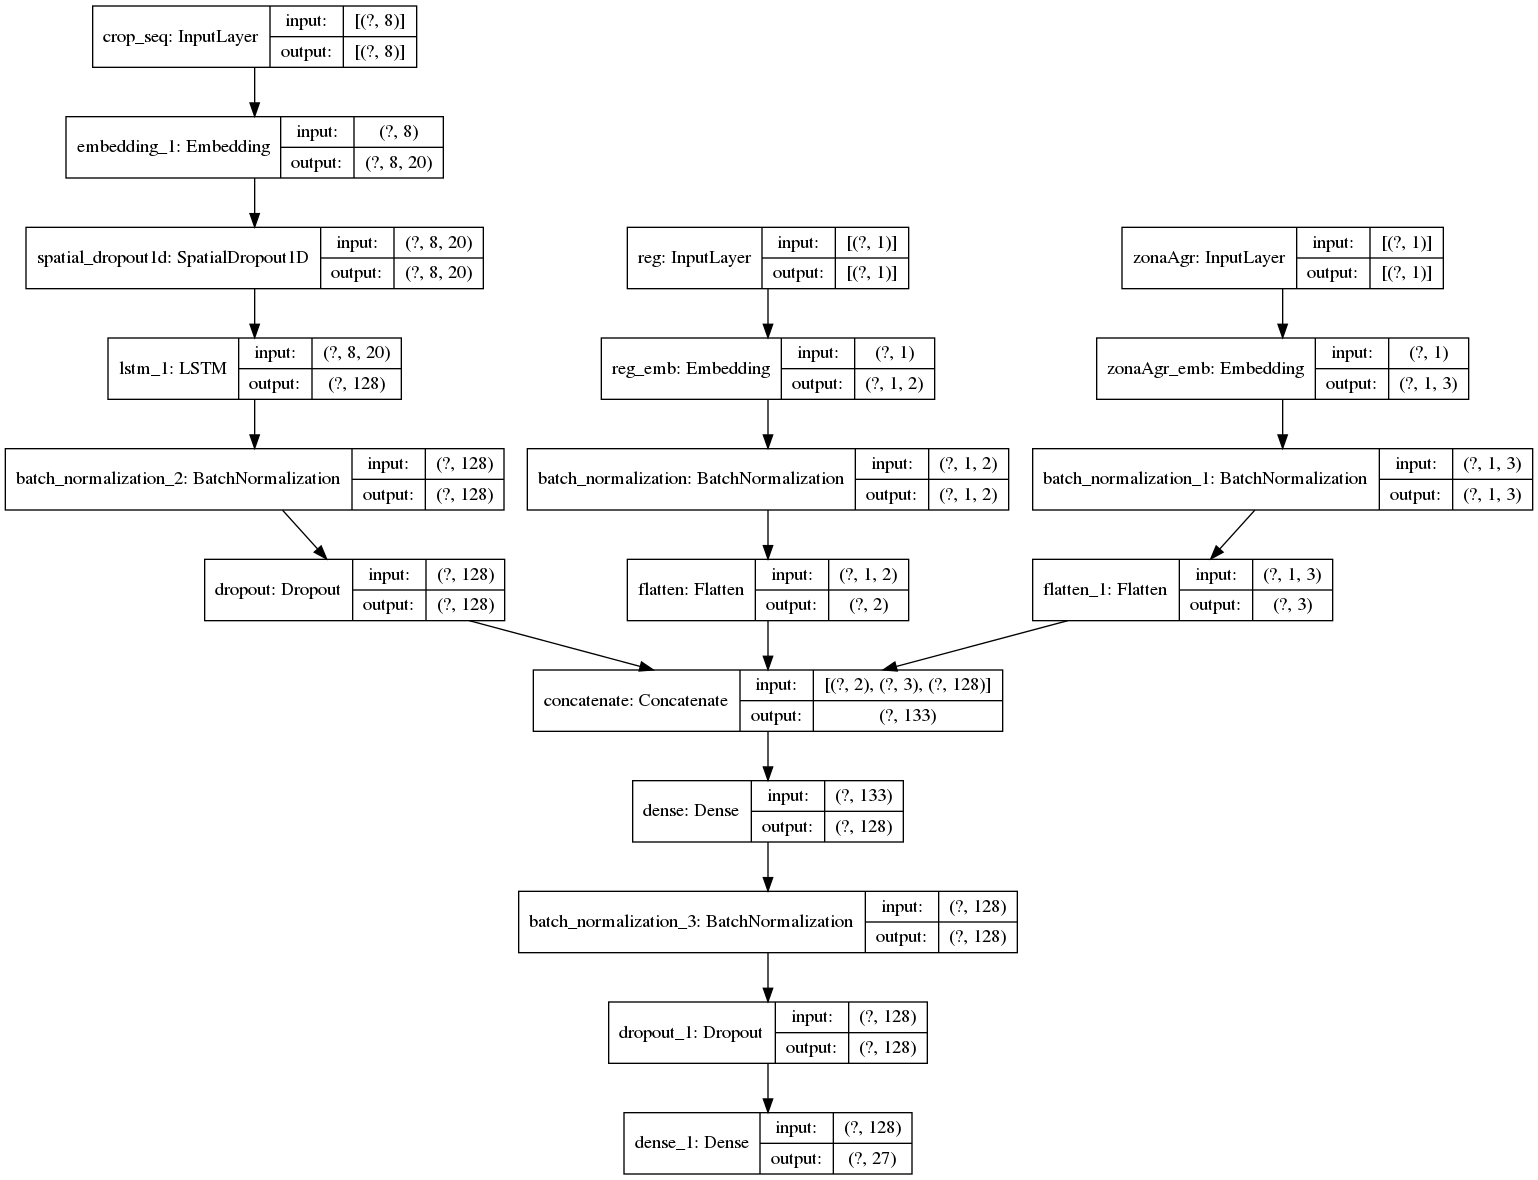

In [7]:
# https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding
# cat_cols = ["reg","exp","zonaAgr"]
# cat_vocab = [(X_train[:,0].max()+1), (X_train[:,1].max()+1), (X_train[:,2].max()+1)]
# cat_size = [2, 100, 5]

cat_cols = ["reg","zonaAgr"]
cat_vocab = [(X_train[:,0].max()+1),(X_train[:,2].max()+1)]
cat_size = [2, 3]

K.clear_session()

vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = basic_lstm(cat_cols, cat_vocab, cat_size)

tag = "lstm_v2"

tf.keras.utils.plot_model(model, show_shapes = True)

In [8]:
EXP_FOLDER = "multemb"

crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()


training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

    
epochs=200

model.compile(**training_params)

folder = create_training_folder(EXP_FOLDER, tag)

#     lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    
# concatenate inputs    
x_train_data = [X_train[:,0], X_train[:,2], X_train[:,3:11]]
x_test_data = [X_test[:,0], X_test[:,2], X_test[:,3:11]]
    
train(model, x_train_data, y_train, x_test_data, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)




/home/gus/workspaces/wpy/venvs/mathor/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


Epoch 1/200

Epoch 00001: val_f1 improved from -inf to 0.51197, saving model to /home/gus/workspaces/wpy/IACapstone/results/multemb/20200809_093605_lstm_v2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/multemb/20200809_093605_lstm_v2/assets
687/687 - 8s - loss: 0.5753 - f1: 0.4275 - val_loss: 0.4867 - val_f1: 0.5120
Epoch 2/200

Epoch 00002: val_f1 improved from 0.51197 to 0.58469, saving model to /home/gus/workspaces/wpy/IACapstone/results/multemb/20200809_093605_lstm_v2
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/multemb/20200809_093605_lstm_v2/assets
687/687 - 7s - loss: 0.4474 - f1: 0.5528 - val_loss: 0.4143 - val_f1: 0.5847
Epoch 3/200

Epoch 00003: val_f1 improved from 0.58469 to 0.60839, saving model to /home/gus/workspaces/wpy/IACapstone/results/multemb/20200809_093605_lstm_v2
INFO:tensorflow:Assets written to: /home/gus/workspaces

KeyboardInterrupt: 

In [ ]:
loss = model.evaluate(x_test_data, y_test, verbose=0)
print("Loss : {}".format(loss))

# evaluate
y_hat = model.predict(x_test_data)
eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)